# Text Summarization using BERT

### Dataset : 
Indian News Summary from https://www.kaggle.com/sunnysai12345/news-summary?select=news_summary.csv

The dataset consists of 4515 examples and contains Author_name, Headlines, Url of Article, Short text, Complete Article. I gathered the summarized news from Inshorts and only scraped the news articles from Hindu, Indian times and Guardian. Time period ranges from febrauary to august 2017.

### Model 
bert-small2bert-small-finetuned-cnn_daily_mail-summarization

https://huggingface.co/mrm8488/bert-small2bert-small-finetuned-cnn_daily_mail-summarization

## Loading Google Drive
Run if you're running this notebook on Google Colab to ease saving result process

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Load Packages

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords   

import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import re           
from bs4 import BeautifulSoup 
pd.set_option("display.max_colwidth", 200)
import warnings
warnings.filterwarnings("ignore")

# DL Library
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizerFast, EncoderDecoderModel
import torch

# Metrics
from rouge import Rouge

print("TensorFlow Version:",tf.__version__)
print("Keras Version:",keras.__version__)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JonathanK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TensorFlow Version: 2.7.0
Keras Version: 2.7.0


## Retrieve Dataset

### Option 1 : Retrieve data using Kaggle API

#### Upload Kaggle.json

**Run this code when using Google Colab**

You can get the file from Kaggle.com > Account > API > Create New API Token

In [ ]:
# only run this in google colab to upload data
from google.colab import files

print("Upload your kaggle.json")
uploaded = files.upload()

Upload your kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
# Copy the JSON file to root directory and change the file permission
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Download the Dataset

In [5]:
!kaggle datasets download -d sunnysai12345/news-summary

^C




  0%|          | 0.00/19.8M [00:00<?, ?B/s]
  5%|▌         | 1.00M/19.8M [00:00<00:06, 3.07MB/s]
 10%|█         | 2.00M/19.8M [00:00<00:05, 3.39MB/s]
 15%|█▌        | 3.00M/19.8M [00:00<00:04, 3.78MB/s]
 20%|██        | 4.00M/19.8M [00:01<00:04, 3.79MB/s]
 25%|██▌       | 5.00M/19.8M [00:01<00:03, 4.36MB/s]
 30%|███       | 6.00M/19.8M [00:01<00:03, 3.69MB/s]
 35%|███▌      | 7.00M/19.8M [00:01<00:03, 3.88MB/s]
 40%|████      | 8.00M/19.8M [00:02<00:02, 4.15MB/s]
 46%|████▌     | 9.00M/19.8M [00:02<00:02, 4.08MB/s]
 51%|█████     | 10.0M/19.8M [00:02<00:02, 3.80MB/s]
 56%|█████▌    | 11.0M/19.8M [00:02<00:02, 4.36MB/s]
 61%|██████    | 12.0M/19.8M [00:03<00:01, 4.14MB/s]
 66%|██████▌   | 13.0M/19.8M [00:03<00:02, 2.65MB/s]
 71%|███████   | 14.0M/19.8M [00:05<00:04, 1.46MB/s]
 76%|███████▌  | 15.0M/19.8M [00:05<00:03, 1.54MB/s]
 81%|████████  | 16.0M/19.8M [00:06<00:02, 1.80MB/s]
 86%|████████▌ | 17.0M/19.8M [00:06<00:01, 1.99MB/s]
 91%|█████████ | 18.0M/19.8M [00:07<00:00, 2.19MB/s]
 

Unzip the data

In [ ]:
!unzip news-summary.zip

Archive:  news-summary.zip
  inflating: news_summary.csv        
  inflating: news_summary_more.csv   


In [ ]:
dataset_path = "news_summary.csv"

### Option 2 : Load data locally

In [2]:
dataset_path = "Dataset/news_summary.csv"

## Load Data

In [14]:
original_data = pd.read_csv(dataset_path, encoding = "ISO-8859-1")
original_data.shape

(4514, 6)

In [18]:
data = pd.read_csv(dataset_path, encoding = "ISO-8859-1") 
print(data.shape)
data.sample(5)

(4514, 6)


,author,date,headlines,read_more,text,ctext
2529,Chhavi Tyagi,"12 Jul 2017,Wednesday",164% rise in terror-related civilian deaths in J&K in a year,http://www.hindustantimes.com/india-news/amarnath-yatra-attack-164-rise-in-terror-related-civilian-deaths-in-kashmir-over-a-year/story-CYrrsoBJcbnLplM2Q4BTGO.html?utm_source=inshorts&utm_medium=re...,"Jammu and Kashmir has witnessed a 45% rise in terrorism-related deaths and 164% increase in civilian deaths alone over the last one year, according to an IndiaSpend analysis of data from the South...","The killing of seven Hindu pilgrims in southern Kashmir en route from the holy cave of Amarnath is the latest bloody statistic in Jammu & Kashmir (J&K), which has witnessed a 45% rise in terrorism..."
2308,Gaurav Shroff,"16 Jul 2017,Sunday",Marine life thrives on island 71 yrs after 23 nuclear tests,https://www.theguardian.com/world/2017/jul/15/quite-odd-coral-and-fish-thrive-on-bikini-atoll-70-years-after-nuclear-tests?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,"Stanford researchers have found an abundance of marine life at Bikini Atoll island, which was declared a nuclear wasteland after the US tested 23 bombs between 1946-1958, including one 1,100 times...","The former island paradise of Bikini Atoll is slowing blooming back to life, 70 years after the United States dropped 23 nuclear bombs on it, including a device in 1954 that was 1,100-times larger..."
4154,Anmol Sharma,"22 Mar 2017,Wednesday",Jadeja has started to come out of Ashwin's shadow: Ganguly,http://indiatoday.intoday.in/story/ravindra-jadeja-ravichandran-ashwin-sourav-ganguly-india-vs-australia-test-cricket/1/909400.html,"After Ravindra Jadeja became sole top-ranked Test bowler, former captain Sourav Ganguly said that Jadeja has started to come out of the shadow of Ravichandran Ashwin. ""Ashwin has 250 Test wickets....",Left-arm spinner Ravindra Jadeja on Tuesday became only the third Indian in history to climb to the top of the ICC rankings for Test bowlers but his rise to the top comes as no surprise to former ...
332,Rini Sinha,"28 Jul 2017,Friday",Was told I'm too good looking to look real in films: Kriti,http://www.hindustantimes.com/bollywood/kriti-sanon-on-her-struggling-days-i-was-told-i-m-too-good-looking-to-be-an-actor/story-QeIRq6Ey6Yxkhw5iXPAx0H.html?utm_source=inshorts&utm_medium=referral&...,"Actress Kriti Sanon has said that when she was struggling to enter films, somebody told her she was too good-looking and there have to be imperfections for looking real onscreen. She added, ""I thi...","Although actor Kriti Sanon is just three films old, she has already been directed by some of the best filmmakers and co-starred with actors such as Shah Rukh Khan and Kajol. However, it wasn?t an ..."
302,Aarushi Maheshwari,"29 Jul 2017,Saturday","Russia-bound man held with ?50,000 in cash at Delhi Airport",http://indiatoday.intoday.in/story/russia-bound-man-held-with-euro-50000-at-delhi-airport/1/1013655.html?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,"A Russia-bound man was arrested at Delhi Airport on Friday for allegedly carrying ?50,000 (nearly ?40 lakh) in an unauthorised manner, a senior official has said. The passenger, identified as Rohi...","New Delhi, Jul 28 (PTI) A Russia-bound man was today apprehended at the Delhi airport for allegedly carrying Euro 50,000 in an unauthorised manner, a senior official said."


Drop duplicates and NA values

In [19]:
data.drop_duplicates(subset=['text'], inplace=True) 
data.dropna(axis=0, inplace=True)
data.shape

(4396, 6)

Rename column

In [20]:
data = data.rename(columns={"text":"summary"})
data = data.rename(columns={"ctext":"text"})
data.head(5)

,author,date,headlines,read_more,summary,text
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in offices order,http://www.hindustantimes.com/india-news/rakshabandhan-compulsory-in-daman-and-diu-women-employees-to-tie-rakhis-to-male-colleagues/story-E5h5U1ZDJii5zFpLXWRkhJ.html?utm_source=inshorts&utm_medium...,The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The...,The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart o...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorcing rich man',http://www.hindustantimes.com/bollywood/malaika-arora-khan-was-trolled-for-divorcing-a-rich-man-her-reply-is-dignity-itself/story-oIPZNI9deImCmabLMMwR2H.html?utm_source=inshorts&utm_medium=referra...,"Malaika Arora slammed an Instagram user who trolled her for ""divorcing a rich man"" and ""having fun with the alimony"". ""Her life now is all about wearing short clothes, going to gym or salon, enjoy...","From her special numbers to TV?appearances, Bollywood actor Malaika Arora Khan has managed to carve her own identity. The actor, who made her debut in the Hindi film industry with the blockbuster ..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS' form,http://www.hindustantimes.com/patna/bihar-igims-form-loses-virginity-after-row-opts-for-unmarried-instead/story-8XmHIg39otGBoZAYEBQxMK.html?utm_source=inshorts&utm_medium=referral&utm_campaign=ful...,"The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna on Thursday made corrections in its Marital Declaration Form by changing 'Virgin' option to 'Unmarried'. Earlier, Bihar Health Mini...","The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patna amended its marital declaration form on Thursday, replacing the word ?virgin? with ?unmarried? after controversy.Until now, new rec..."
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before being killed,http://indiatoday.intoday.in/story/abu-dujana-last-phone-call-lashkar-e-taiba-jammu-and-kashmir/1/1017550.html?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle,"Lashkar-e-Taiba's Kashmir commander Abu Dujana, who was killed by security forces, said ""Kabhi hum aage, kabhi aap, aaj aapne pakad liya, mubarak ho aapko (Today you caught me. Congratulations)"" a...","Lashkar-e-Taiba's Kashmir commander Abu Dujana was killed in an encounter in a village in Pulwama district of Jammu and Kashmir earlier this week. Dujana, who had managed to give the security forc..."
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of sex trafficking,http://indiatoday.intoday.in/story/sex-trafficking-mumbai-rescue-me-maharashtra-international-labour-organization-forced-labour-trafficking-traning-hotel-staff/1/1017210.html?utm_source=inshorts&u...,"Hotels in Maharashtra will train their staff to spot signs of sex trafficking, including frequent requests for bed linen changes and 'Do not disturb' signs left on room doors for days. A mobile ph...","Hotels in Mumbai and other Indian cities are to train their staff to spot signs of sex trafficking such as frequent requests for bed linen changes or a ""Do not disturb"" sign left on the door for d..."


## Exploratory Data Analysis
Understanding the distribution of text sequence

We want to analyze the length of revieiws and summary to get an idea of the distribution of length of the sequence

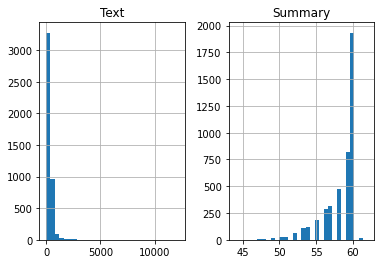

In [21]:
text_word_count = []
summary_word_count = []

# Populate the lists with sentence lengths
for i in data['text']:
      text_word_count.append(len(i.split()))

for i in data['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Text':text_word_count, 'Summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

Calculating the proportion of text

In [24]:
count = 0
for i in data['text']:
  if(len(i.split()) <= 700):
    count = count+1
print(count/len(data['text']))

0.9444949954504095


Calculating the proportion of summary

In [27]:
cnt=0
for i in data['summary']:
    if(len(i.split())<=60):
        cnt=cnt+1
print(cnt/len(data['summary']))

0.9963603275705186


We can observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8

## Generate Summary Function

In [31]:
tokenizer = BertTokenizerFast.from_pretrained('mrm8488/bert-small2bert-small-finetuned-cnn_daily_mail-summarization')
model = EncoderDecoderModel.from_pretrained('mrm8488/bert-small2bert-small-finetuned-cnn_daily_mail-summarization')




























































































































































































































































































































































































































































































































































































































Downloading: 100%|██████████| 236M/236M [01:14<00:00, 3.33MB/s]


In [32]:
def generate_summary(text):
    # Cut off at BERT max length 512
    inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    output = model.generate(input_ids, attention_mask=attention_mask)

    return tokenizer.decode(output[0], skip_special_tokens=True)

## Generate Summary

In [33]:
# Ground Truth
original_summary = []
for t in data['text']:
    original_summary.append(t)
original_summary[0:10]

['The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Dam

In [34]:
text = []
for t in data['text']:
    text.append(t)
text[0:10]

['The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Dam

In [35]:
output_summary = []
for idx, txt in enumerate(text):
  print("Text -", idx)
  res = generate_summary(txt)
  output_summary.append(res)

len(output_summary)

Text - 0
Text - 1
Text - 2
Text - 3
Text - 4
Text - 5
Text - 6
Text - 7
Text - 8
Text - 9
Text - 10
Text - 11
Text - 12
Text - 13
Text - 14
Text - 15
Text - 16
Text - 17
Text - 18
Text - 19
Text - 20
Text - 21
Text - 22
Text - 23
Text - 24
Text - 25
Text - 26
Text - 27
Text - 28
Text - 29
Text - 30
Text - 31
Text - 32
Text - 33
Text - 34
Text - 35
Text - 36
Text - 37
Text - 38
Text - 39
Text - 40
Text - 41
Text - 42
Text - 43
Text - 44
Text - 45
Text - 46
Text - 47
Text - 48
Text - 49
Text - 50
Text - 51
Text - 52
Text - 53
Text - 54
Text - 55
Text - 56
Text - 57
Text - 58
Text - 59
Text - 60
Text - 61
Text - 62
Text - 63
Text - 64
Text - 65
Text - 66
Text - 67
Text - 68
Text - 69
Text - 70
Text - 71
Text - 72
Text - 73
Text - 74
Text - 75
Text - 76
Text - 77
Text - 78
Text - 79
Text - 80
Text - 81
Text - 82
Text - 83
Text - 84
Text - 85
Text - 86
Text - 87
Text - 88
Text - 89
Text - 90
Text - 91
Text - 92
Text - 93
Text - 94
Text - 95
Text - 96
Text - 97
Text - 98
Text - 99
Text - 100

4396

In [36]:
# Output Summary
output_summary[0:10]

['the union territory? s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate rakshabandhan at workplace. the order was issued late in the evening by the ut? s department of personnel and administrative reforms. a year earlier, women ministers in the modi government went to the border areas to celebrate the festival with soldiers.',
 "malaika arora shared a gorgeous picture of herself on instagram and a follower decided to troll her for using her? malaika has played all the roles traditionally prescribed for a woman. the details of the alimony are known to malaika, her husband arbaaz khan and perhaps the family's family.",
 'until now, new recruits were required to declare if they were bachelors, widowers or virgins. bihar health minister mangal pandey had ended up redefining the very meaning of virginity in his attempt to justify the awkward phrasing of the question in the form.',
 "dujana was killed in an enco

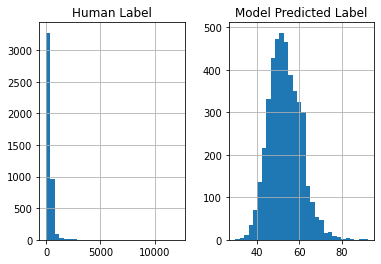

In [37]:
human_label = []
model_predicted_label = []

# populate the lists with sentence lengths
for i in original_summary:
      human_label.append(len(i.split()))

for i in output_summary:
      model_predicted_label.append(len(i.split()))

length_df = pd.DataFrame({'Human Label':human_label, 'Model Predicted Label':model_predicted_label})
length_df.hist(bins = 30)
plt.show()

In [38]:
rouge = Rouge()

In [39]:
rouge.get_scores(output_summary, original_summary, avg=True)

Downloading:  32%|███▏      | 76.4M/236M [2:53:47<6:02:09, 7.69kB/s]


{'rouge-1': {'r': 0.20755426221796697,
  'p': 0.7337986214557163,
  'f': 0.3076920529110193},
 'rouge-2': {'r': 0.13241665866977642,
  'p': 0.5546959001829123,
  'f': 0.19873106489027592},
 'rouge-l': {'r': 0.20546071300187677,
  'p': 0.7265463213381619,
  'f': 0.3046322345980435}}

## Output Text

In [40]:
final_result_df = pd.DataFrame()
final_result_df['Human Summary'] = original_summary
final_result_df['Model Predicted Summary'] = output_summary

In [41]:
output_path = "Result/SmallBERT_result_no_preprocess.csv"
final_result_df.to_csv(output_path)

### Result Preview

In [ ]:
result_preview_df = pd.read_csv("Result/SmallBERT_result_no_preprocess.csv")

In [5]:
print("Human Summary")
print("="*20)
result_preview_df['Human Summary'][0]

Human Summary


'The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Dama

In [6]:
print("Model Predicted Summary")
print("="*20)
result_preview_df['Model Predicted Summary'][0]

Model Predicted Summary


'the union territory? s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate rakshabandhan at workplace. the order was issued late in the evening by the ut? s department of personnel and administrative reforms. a year earlier, women ministers in the modi government went to the border areas to celebrate the festival with soldiers.'